In [1]:
from typing import List, Any
import sys
sys.path.append('C:/Users/TomFi/Desktop/Cours/Projet IA/neuroforest-master')
sys.path.append('C:/Users/TomFi/Desktop/Cours/Projet IA/deepHL')
import numpy as np
import pandas as pd
import random as rd
import optuna
import json
import os
import time
from tqdm import tqdm
from IPython import display
from PIL import Image, ImageDraw, ImageFont
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from main import to_vect, Coordinates, calculate_asrs, dataloader, dataloader_2024

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchsummary


Loading data from : C:\Users\TomFi\Desktop\Cours\Projet IA\data_2022\trajectories_processed
Loading data from : C:\Users\TomFi\Desktop\Cours\Projet IA\data_2024\trajectories_processed


In [2]:
def classify_asrs(questionnaire_answers: dict[str, Any]) -> int:
    thresholds = 5
    count_grey = 0
    for column_name, value in questionnaire_answers.items():
        if column_name.startswith("asrs"):
            if int(column_name[-1]) in [1,2,3,12,16,18]:
                threshold = 3
            else:
                threshold = 4
            if int(value) >= threshold:
                count_grey += 1
    return count_grey


In [3]:
def create_batches(dataloader, session_type: str, batch_size: int, scale : int = 20,
                   subsample : bool = False, asrs_calc = classify_asrs, augmentation : bool = False, shuffle : bool = True):
    trajectories = []
    asrs = []
    print("Iterating through dataloader...")
    for sample in tqdm(dataloader):
        session = sample[session_type]
        if session is not None:
            if sample.answers is not None:
                player_coords = np.array([c["coord"].to_vect() for c in session.player_coords])
                player_coords = player_coords[:, [0, 2]]  # Keep only x and z coordinates
                asrs_score = asrs_calc(sample.answers)
                if augmentation:
                    # Add 8 different rotations of the trajectory
                    for i in range(0, 8):
                        # rotate from 45°
                        theta = np.radians(45*i)
                        c, s = np.cos(theta), np.sin(theta)
                        R = np.array([[c, -s], [s, c]])
                        rotated_coords = np.dot(player_coords, R)
                        trajectories.append(rotated_coords)
                        asrs_std = 3.1191546250994713
                        ICC = 0.75
                        intraclass_var = asrs_std**2 * (1/ICC - 1)
                        simulated_asrs = rd.gauss(asrs_score, intraclass_var)
                        asrs.append(asrs_score)

                else :
                    trajectories.append(player_coords)
                    asrs.append(asrs_score)
    print(len(trajectories), "trajectories found.")

    # Pad / Truncate trajectories
    length = 30000
    padded_trajectories = []
    for traj in trajectories:
        if len(traj) < length:
            padded_traj = np.pad(traj, ((0, length - len(traj)), (0, 0)), mode='edge')
        else :
            padded_traj = traj
        truncated_traj = padded_traj[:length]
        padded_trajectories.append(truncated_traj)

    # Subsample trajectories
    if subsample:
        length = length // scale
        trajectories = np.array([np.array_split(player_coords, scale) for player_coords in padded_trajectories])
        trajectories = np.concatenate(trajectories, axis=0)
        trajectories = [coords - coords[0] for coords in trajectories]
        asrs = np.array([asrs_score for asrs_score in asrs for _ in range(scale)])
    else:
        trajectories = list(padded_trajectories)  

    # Shuffle trajectories
    tensor_trajectories = torch.tensor(list(trajectories), dtype=torch.float32)
    if shuffle :
        seed = 42
        permute = torch.randperm(len(tensor_trajectories), generator=torch.Generator().manual_seed(seed))
        tensor_trajectories = tensor_trajectories[permute]
        asrs = np.array(asrs)[permute]

    # Create batches
    num_batches = min(len(tensor_trajectories), len(asrs)) // batch_size
    if len(asrs) == len(trajectories):
        batches = tensor_trajectories[:num_batches * batch_size].view(num_batches, batch_size, length, 2)
        asrs = torch.tensor(np.array(asrs[:num_batches * batch_size])).view(num_batches, batch_size)
        # Reduce the sample rate
        batches = batches[:, :, ::5]    

    return batches, asrs

In [ ]:
with open('C:/Users/TomFi/Desktop/Cours/Projet IA/index.txt') as f:
    lines = f.readlines()
for line in lines :
    filename, path, sheet_name = line.split(',')
    class_name = sheet_name.split('_')[0]
    for folder_name in 'feature', 'trajectory':
        path_to_get = 'C:/Users/TomFi/Desktop/Cours/Projet IA/' + folder_name + '/' + filename
        path_to_save = 'C:/Users/TomFi/Desktop/Cours/Projet IA/' + class_name + '/' + folder_name + '/' + filename
        os.makedirs(os.path.dirname(path_to_save), exist_ok=True)
        # copy file to target folder
        with open(path_to_get, 'rb') as f:
            with open(path_to_save, 'wb') as f2:
                f2.write(f.read())


In [43]:
def data_setup(dataloader = dataloader, scale : int = 5, batch_size : int = 60, augmentation : bool = False,
               return_asrs : bool = False):
    # Create batches for "uniform" and "patchy" session types
    uniform_batches,asrs = create_batches(dataloader, "uniform", batch_size, subsample=True, asrs_calc = calculate_asrs, scale=scale, augmentation=augmentation, shuffle=True)
    patchy_batches,asrs_2 = create_batches(dataloader, "patchy", batch_size, subsample=True, asrs_calc = calculate_asrs, scale=scale, augmentation=augmentation, shuffle=True)
    asrs = torch.cat((asrs, asrs_2), 0)
    batches = torch.cat((uniform_batches, patchy_batches), 0)
    high_probability_adhd = torch.Tensor((np.array(asrs) >= 4).astype(int))

    print(f"Trajectory batches shape: {batches.shape}")
    print(f"Target batches shape: {asrs.shape}")

    if return_asrs:
        return batches, asrs
    return batches, high_probability_adhd

In [169]:
def create_excels(trajectories, binary, dir):
    print("Creating excel files...")
    count_0 = 0
    count_1 = 0
    for i, (trajectory, adhd_class) in enumerate(zip(trajectories, binary)):
        df = pd.DataFrame(trajectory, columns=["x", "y"])
        if adhd_class == 0:
            count_0 += 1
            with pd.ExcelWriter(path = dir + f"trajectories_0.xlsx", mode = 'a', if_sheet_exists='replace') as f:
                df.to_excel(f, sheet_name=f'Class0_{count_0}')
        else:
            count_1 += 1
            with pd.ExcelWriter(path = dir + f"trajectories_1.xlsx", mode = 'a', if_sheet_exists='replace') as f:
                df.to_excel(f, sheet_name=f'Class1_{count_1}')

# Test different scales

Creating batches...


  0%|          | 0/39 [00:00<?, ?it/s]

100%|██████████| 39/39 [00:22<00:00,  1.73it/s]


Creating batches...


100%|██████████| 39/39 [00:21<00:00,  1.78it/s]


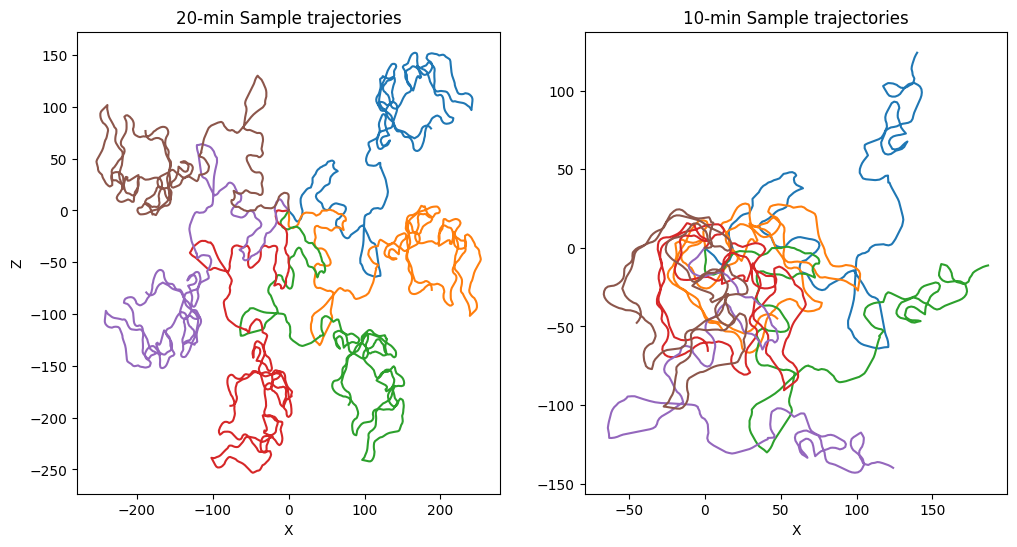

In [21]:
batch_size = 6
scales = [1,2]
x_1, _ = create_batches(dataloader, "uniform", batch_size, scale=scales[0], subsample=True, augmentation=True, shuffle=False)
x_2, _ = create_batches(dataloader, "uniform", batch_size, scale=scales[1], subsample=True, augmentation=True, shuffle=False)
duration_1, duration_2 = x_1.shape[2]//60, x_2.shape[2]//60

# Plot the first 10 trajectories
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for i in range(batch_size):
    axes[0].plot(x_1[0, i, :, 0].flatten(), x_1[0, i, :, 1].flatten(), label=f'{duration_1}-min trajectories {i+1}')
    axes[1].plot(x_2[0, i, :, 0].flatten(), x_2[0, i, :, 1].flatten(), label=f'{duration_2}-min trajectories {i+1}')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Z')
axes[0].set_title(f'{duration_1}-min Sample trajectories')
axes[1].set_xlabel('X')
axes[1].set_title(f'{duration_2}-min Sample trajectories')
plt.show()

# Model definition

In [77]:
class LSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout, seq_len):
        super(LSTMWithAttention, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=1, dropout=dropout)
        self.dense1 = nn.Linear(hidden_dim, 1)
        self.dense2 = nn.Linear(seq_len,1)
        self.activation = nn.Sigmoid()
        self.seq_len = seq_len
        self.init_weights()
        

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.xavier_normal_(param)
            else:
                nn.init.zeros_(param)


    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out.permute(1, 0, 2)
        attention_out = self.attention(lstm_out, lstm_out, lstm_out)[0]
        dense_out = self.dense1(attention_out).view(-1, self.seq_len)
        dense_out = self.dense2(dense_out)
        probability = self.activation(dense_out)
        return probability

# Define the model parameters
input_dim = 2  # x and z coordinates
hidden_dim = 64
num_layers = 4
dropout = 0.5

In [5]:
class TemporalCNN(nn.Module):
    def __init__(self, seq_len, n_channels=2, num_classes=1,
                 conv_params_1 : dict = {"channels" : 8, "kernel_size": 20, "stride": 1},
                 conv_params_2 : dict = {"channels" : 16, "kernel_size": 5, "stride": 1},
                 conv_params_3 : dict = {"channels" : 32, "kernel_size": 3, "stride": 1},
                 conv_params_4 : dict = {"channels" : 64, "kernel_size": 3, "stride": 1},):
    
        super(TemporalCNN, self).__init__()

        def calculate_seq_len(seq_len, kernel_size, stride, padding):
            return (seq_len - kernel_size + 2 * padding) // stride + 1

        # 1 convolution
        channels_1 = conv_params_1["channels"]
        kernel_size_1 = conv_params_1["kernel_size"]
        stride_1 = conv_params_1["stride"]
        self.conv1 = nn.Conv1d(n_channels, out_channels=channels_1, kernel_size=kernel_size_1, stride=stride_1, padding=1, bias=False)
        self.seq_len = calculate_seq_len(seq_len, kernel_size_1, stride_1, 1)

        self.bn1 = nn.BatchNorm1d(channels_1)

        # Second convolution
        channels_2 = conv_params_2["channels"]
        kernel_size_2 = conv_params_2["kernel_size"]
        stride_2 = conv_params_2["stride"]
        self.conv2 = nn.Conv1d(channels_1, channels_2, kernel_size=kernel_size_2, stride=stride_2, padding=1, bias = False)
        self.seq_len = calculate_seq_len(self.seq_len, kernel_size_2, stride_2, 1)

        # BatchNorm       
        self.bn2 = nn.BatchNorm1d(channels_2)

        # Third convolution
        channels_3 = conv_params_3["channels"]
        kernel_size_3 = conv_params_3["kernel_size"]
        stride_3 = conv_params_3["stride"]
        self.conv3 = nn.Conv1d(channels_2, channels_3, kernel_size=kernel_size_3, stride=stride_3, padding=1, bias = False)
        self.seq_len = calculate_seq_len(self.seq_len, kernel_size_3, stride_3, 1)

        # BatchNorm
        self.bn3 = nn.BatchNorm1d(channels_3)

        # # Fourth convolution
        # channels_4 = conv_params_4["channels"]
        # kernel_size_4 = conv_params_4["kernel_size"]
        # stride_4 = conv_params_4["stride"]
        # self.conv4 = nn.Conv1d(channels_3, channels_4, kernel_size=kernel_size_4, stride=stride_4, padding=1, bias=False)
        # self.seq_len = calculate_seq_len(self.seq_len, kernel_size_4, stride_4, 0)

        # # BatchNorm
        # self.bn4 = nn.BatchNorm1d(channels_4)

        # Predictor
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(channels_3, 1)
        self.fc2 = nn.Linear(self.seq_len, num_classes)
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

                    
    def forward(self, x):
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, n_channels, seq_len)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.leaky_relu(x)
        # x = self.conv4(x)
        # x = self.bn4(x)
        # x = self.dropout(x)
        # x = F.leaky_relu(x)
        x = x.permute(0, 2, 1)  # Change shape back to (batch_size, seq_len, n_channels)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = x.permute(0, 2, 1)
        x = self.fc2(x)  # Change shape to (batch_size, 1, seq_len)
        x = F.sigmoid(x)
        return x.squeeze()

In [32]:
class CNN_encoder(nn.Module):
    def __init__(self, seq_len, n_channels=2, num_classes=1,
                 conv_params_1 : dict = {"channels" : 8, "kernel_size": 20, "stride": 1},
                 conv_params_2 : dict = {"channels" : 16, "kernel_size": 5, "stride": 1},
                 conv_params_3 : dict = {"channels" : 32, "kernel_size": 3, "stride": 1},
                ):
    
        super().__init__()

        def calculate_seq_len(seq_len, kernel_size, stride, padding):
            new_len = (seq_len - kernel_size + 2 * padding) // stride + 1
            return new_len

        # 1 convolution
        channels_1 = conv_params_1["channels"]
        kernel_size_1 = conv_params_1["kernel_size"]
        stride_1 = conv_params_1["stride"]
        self.conv1 = nn.Conv1d(n_channels, out_channels=channels_1, kernel_size=kernel_size_1, stride=stride_1, padding=kernel_size_1//2, bias=False)
        self.seq_len = calculate_seq_len(seq_len, kernel_size_1, stride_1, kernel_size_1//2)

        self.bn1 = nn.BatchNorm1d(channels_1)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.seq_len = self.seq_len // 2

        # Second convolution
        channels_2 = conv_params_2["channels"]
        kernel_size_2 = conv_params_2["kernel_size"]
        stride_2 = conv_params_2["stride"]
        self.conv2 = nn.Conv1d(channels_1, channels_2, kernel_size=kernel_size_2, stride=stride_2, padding=kernel_size_2//2, bias = False)
        self.seq_len = calculate_seq_len(self.seq_len, kernel_size_2, stride_2, kernel_size_2//2)

        # BatchNorm       
        self.bn2 = nn.BatchNorm1d(channels_2)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.seq_len = self.seq_len // 2

        # Third convolution
        channels_3 = conv_params_3["channels"]
        kernel_size_3 = conv_params_3["kernel_size"]
        stride_3 = conv_params_3["stride"]
        self.conv3 = nn.Conv1d(channels_2, channels_3, kernel_size=kernel_size_3, stride=stride_3, padding=kernel_size_3//2, bias = False)
        self.seq_len = calculate_seq_len(self.seq_len, kernel_size_3, stride_3, kernel_size_3//2)

        # BatchNorm
        self.bn3 = nn.BatchNorm1d(channels_3)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.seq_len = self.seq_len // 2

        # Predictor
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(channels_3, 1)
        self.fc2 = nn.Linear(self.seq_len, num_classes)
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

                    
    def forward(self, x):
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, n_channels, seq_len)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.pool1(x)
        x = F.leaky_relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.pool2(x)
        x = F.leaky_relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.pool3(x)
        x = F.leaky_relu(x)
        x = x.permute(0, 2, 1)  # Change shape back to (batch_size, seq_len, n_channels)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = x.permute(0, 2, 1)
        x = self.fc2(x)  # Change shape to (batch_size, 1, seq_len)
        x = F.sigmoid(x)
        return x.squeeze()

# conv_params_1 = {"channels" : 8 , "kernel_size": 20, "stride": 1}
# conv_params_2 = {"channels" : 16, "kernel_size": 10, "stride": 1}
# conv_params_3 = {"channels" : 32, "kernel_size": 5, "stride": 1}
# test = CNN_encoder(seq_len=seq_len, conv_params_1=conv_params_1, conv_params_2=conv_params_2, conv_params_3=conv_params_3)
# torchsummary.summary(test, (seq_len,2))

# Data preparation

In [44]:
x_2022, y_2022 = data_setup(dataloader=dataloader,scale=4, batch_size=4, augmentation=True, return_asrs=True)
x_2024, y_2024 = data_setup(dataloader=dataloader_2024,scale=4, batch_size=4, augmentation=False, return_asrs=True)
x_all, y_all = torch.cat((x_2022, x_2024), 0), torch.cat((y_2022, y_2024), 0)
seq_len = x_all.shape[2]
print(f"Sequence length: {seq_len}")

Iterating through dataloader...


100%|██████████| 39/39 [00:17<00:00,  2.26it/s]


312 trajectories found.
Iterating through dataloader...


100%|██████████| 39/39 [00:19<00:00,  1.98it/s]


304 trajectories found.
Trajectory batches shape: torch.Size([616, 4, 1500, 2])
Target batches shape: torch.Size([616, 4])
Iterating through dataloader...


100%|██████████| 19/19 [00:07<00:00,  2.43it/s]


19 trajectories found.
Iterating through dataloader...


100%|██████████| 19/19 [00:07<00:00,  2.59it/s]


18 trajectories found.
Trajectory batches shape: torch.Size([37, 4, 1500, 2])
Target batches shape: torch.Size([37, 4])
Sequence length: 1500


In [47]:
# create_excels(x_all.reshape(x_all.shape[0],x_all.shape[2], x_all.shape[3]), y_all.reshape(y_all.shape[0], 1), "C:/Users/TomFi/Desktop/Cours/Projet IA/")
seq_len = x_all.shape[2]
# x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, shuffle = False)
y_train = y_2022.reshape(-1,4)
y_test = y_2024.reshape(-1,4)
x_train = x_2022.reshape(-1, 4, seq_len, 2)
x_test = x_2024.reshape(-1, 4, seq_len, 2)

In [48]:
scaler = MinMaxScaler()
all_asrs = torch.cat((y_train.flatten(), y_test.flatten()), 0)
all_asrs_norm = scaler.fit_transform(all_asrs.reshape(-1,1)).astype(np.float32)
y_train = all_asrs_norm[:y_train.shape[0]*y_train.shape[1]].reshape(y_train.shape)
y_test = all_asrs_norm[y_train.shape[0]*y_train.shape[1]:].reshape(y_test.shape)

In [109]:
def add_quantiles(y, num_cats=4):
    values = torch.linspace(0, 1, num_cats+1)
    quantiles = torch.quantile(y.float(), values)
    y_cats = []
    for score in y.flatten():
        cat = [0, 0, 0, 0]
        if score < quantiles[1]:
            cat[0] = 1
        elif score < quantiles[2]:
            cat[1] = 1
        elif score < quantiles[3]:
            cat[2] = 1
        else:
            cat[3] = 1
        y_cats.append(cat)
    y_cats = torch.tensor(y_cats, dtype=torch.float32)
    y_cats = y_cats.reshape((y.shape[0], num_cats))
    return y_cats

In [110]:
num_categories = 4
asrs_cats = add_quantiles(all_asrs, num_categories)
cats = torch.argmax(asrs_cats, dim=1)
y_train_cats = asrs_cats[:y_train.shape[0]*y_train.shape[1]].reshape((y_train.shape[0], y_train.shape[1], num_categories))
y_test_cats = asrs_cats[y_train.shape[0]*y_train.shape[1]:].reshape((y_test.shape[0], y_test.shape[1], num_categories))

In [212]:
def train(model, x_train, y_train, x_test, y_test, num_epochs : int = 100, learning_rate : float = 0.001,
          monitor_gradients : bool = False, lambda_var : float = 0.1):
    # Define the loss function and optimizer
    criterion = CustomMSELoss(lambda_var=lambda_var)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize plot
    plt.ion()
    fig, ax = plt.subplots(figsize=(12, 6))
    losses = []
    val_losses = []

    # Example training loop
    for epoch in range(num_epochs):
        train_loss = 0
        for batch in range(x_train.shape[0]):
            x_train_batch = x_train[batch]
            y_train_batch = y_train[batch]
            
            model.train()
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(x_train_batch)
            loss = criterion(outputs.squeeze(), torch.tensor(y_train_batch, dtype=torch.float32))
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            train_loss += loss.item()/x_train.shape[0]
            

            # Monitor gradients
            if monitor_gradients : 
                for name, param in model.named_parameters():
                    if param.grad is not None:
                        print(f'{name}: {param.grad.abs().mean()}')

        # add validation on test set
        outputs = []
        for batch in range(x_test.shape[0]):
            x_test_batch = x_test[batch]
            y_test_batch = y_test[batch]            
            outputs.append(model(x_test_batch).squeeze().detach().numpy())
        val_loss = criterion(torch.tensor(outputs).squeeze(), torch.tensor(y_test).squeeze()).item()


        print(f'Epoch {epoch+1}/{num_epochs}, batch {batch+1}/{x_train.shape[0]}, Loss: {train_loss}, Val Loss: {val_loss}')
        
        # Dynamic plot to showcase the evolution of the loss
        losses.append(train_loss)
        val_losses.append(val_loss)
        ax.clear()
        ax.plot(losses, label='Train Loss', c = 'navy')
        ax.plot(val_losses, label='Validation Loss', c= 'r')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title('Training and Validation Loss')
        ax.legend()
        display.clear_output(wait=True)
        display.display(fig) 

    plt.ioff()
    plt.close()

In [221]:
temporal_cnn = TemporalCNN(seq_len, 
                           first_conv_params={"kernel_size": 10, "stride": 5, "padding": 0},
                           second_conv_params={"kernel_size": 5, "stride": 5, "padding": 0})
torchsummary.summary(temporal_cnn, (seq_len, 2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 239]             672
       BatchNorm1d-2              [-1, 32, 239]              64
            Conv1d-3               [-1, 64, 47]          10,304
       BatchNorm1d-4               [-1, 64, 47]             128
           Dropout-5               [-1, 64, 47]               0
            Linear-6                [-1, 47, 1]              65
            Linear-7                 [-1, 1, 1]              48
Total params: 11,281
Trainable params: 11,281
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.19
Params size (MB): 0.04
Estimated Total Size (MB): 0.24
----------------------------------------------------------------


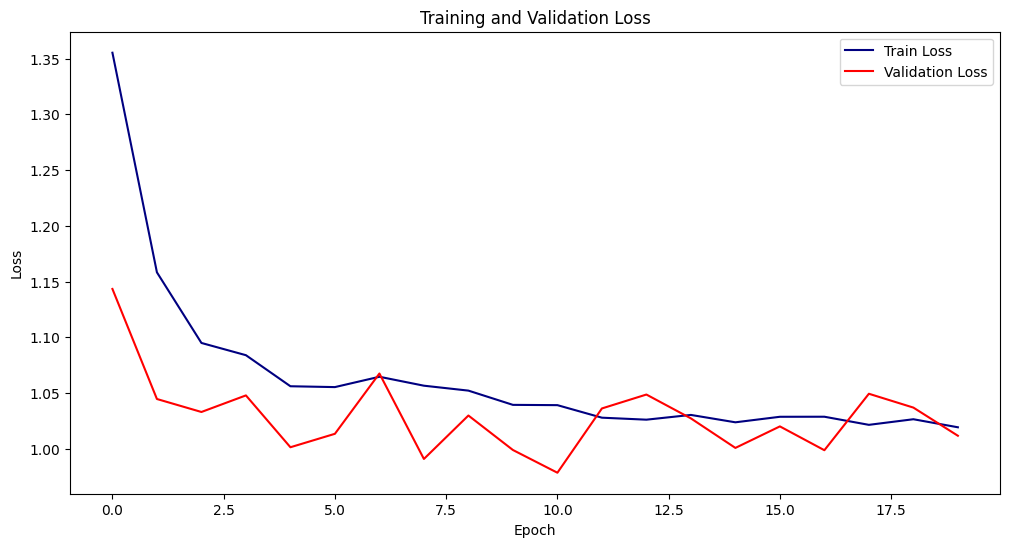

In [222]:
train(temporal_cnn, x_train, y_train, x_test, y_test, num_epochs=20, learning_rate=0.0005, lambda_var=1)

# Evaluating models

In [223]:
def eval_binaryclass(model, x_test, y_test):
    outputs = []
    for batch in range(x_test.shape[0]):
        x_test_batch = x_test[batch]
        outputs.append(model(x_test_batch).squeeze().detach().numpy())
    outputs = np.array(outputs).flatten()
    test_HP_adhd = np.array(y_test).flatten()
    threshold = np.arange(0.02, 0.98, 0.02)
    accuracy, precision, recall = [], [], []
    for t in threshold:
        tp = np.sum((outputs > t) & (test_HP_adhd == 1)) + 1e-10
        tn = np.sum((outputs <= t) & (test_HP_adhd == 0))+ 1e-10
        fp = np.sum((outputs > t) & (test_HP_adhd == 0))+ 1e-10
        fn = np.sum((outputs <= t) & (test_HP_adhd == 1))+ 1e-10
        # print(f"TP : {tp}, TN : {tn}, FP : {fp}, FN : {fn}")
        precision.append(tp / (tp + fp))
        recall.append(tp / (tp + fn))
    f1 = 2 * np.array(precision) * np.array(recall) / (np.array(precision) + np.array(recall))
    plt.plot(threshold, precision, label = 'Precision')
    plt.plot(threshold, recall, label = 'Recall')
    plt.plot(threshold, f1, label = 'F1')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.title('Result metrics vs Threshold')
    plt.legend()
    plt.show()

    return f1, outputs


def eval_score(model, x_test, y_test):
    outputs = []
    for batch in range(x_test.shape[0]):
        x_test_batch = x_test[batch]
        outputs.append(model(x_test_batch).squeeze().detach().numpy())
    outputs = np.array(outputs).flatten()
    test_HP_adhd = np.array(y_test).flatten()
    mse = np.mean((outputs - test_HP_adhd) ** 2)
    print(f'Mean Squared Error: {mse}')
    # plot the results
    plt.plot(outputs, label='Predictions', c = 'g')
    plt.plot(test_HP_adhd, label='True values', c = 'orange')
    plt.legend()
    plt.show()
    return mse, outputs

Mean Squared Error: 0.12995147705078125


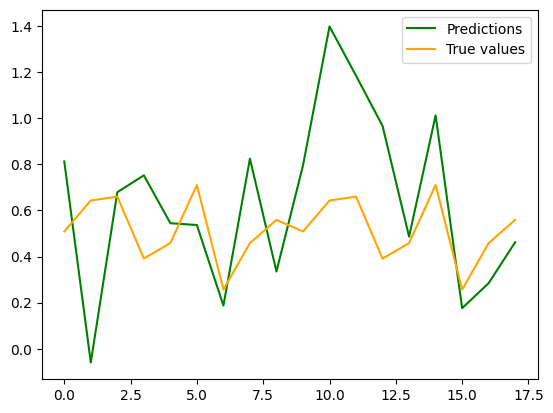

In [224]:
mse, ouputs = eval_score(temporal_cnn, x_test, y_test)

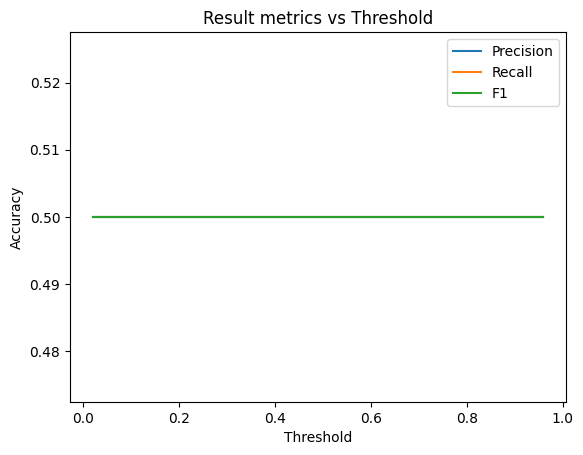

In [ ]:
f1 = eval_binaryclass(temporal_cnn, x_test, y_test)

In [94]:
id_threshold = np.argmax(f1)
max_f1 = f1[id_threshold]
print(f"Best threshold : {id_threshold * 0.02 + 0.02}, achieving F1 score of {max_f1}")

Best threshold : 0.02, achieving F1 score of 0.5


<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\s'
C:\Users\TomFi\AppData\Local\Temp\ipykernel_26072\4226674619.py:14: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x, p, 'k', linewidth=2, label=f'Fit: $\mu={mu}$, $\sigma={std}$')
C:\Users\TomFi\AppData\Local\Temp\ipykernel_26072\4226674619.py:14: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x, p, 'k', linewidth=2, label=f'Fit: $\mu={mu}$, $\sigma={std}$')


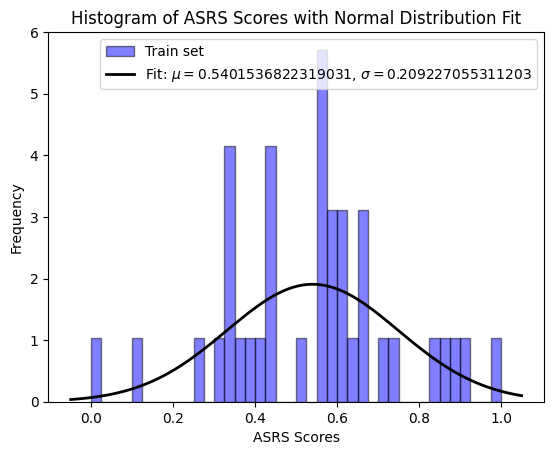

In [220]:
from scipy.stats import norm

# Fit a normal distribution to the data
mu, std = norm.fit(y_train.flatten())

# Plot the histogram
plt.hist(y_train.flatten(), bins=40, alpha=0.5, label='Train set', color='blue', edgecolor='black', density=True)
# plt.hist(y_test.flatten(), bins=40, alpha=0.5, label='Test set', color='red', edgecolor='black', density=True)

# Plot the PDF
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label=f'Fit: $\mu={mu}$, $\sigma={std}$')

# Add labels and title
plt.xlabel('ASRS Scores')
plt.ylabel('Frequency')
plt.title('Histogram of ASRS Scores with Normal Distribution Fit')
plt.legend()
plt.show()

# Training

In [12]:
# Define the custom MSE loss function
class CustomMSELoss(nn.Module):
    def __init__(self, lambda_var = 0.5):
        super(CustomMSELoss, self).__init__()
        self.mse_loss = nn.MSELoss()
        self.KL = nn.KLDivLoss()
        self.lambda_var = lambda_var

    def forward(self, outputs, targets):
        mse_loss = self.mse_loss(outputs, targets)
        entropy = -outputs * torch.log(outputs) - (1 - outputs) * torch.log(1 - outputs)
        variance_pen = torch.abs(torch.var(outputs) - 0.2)
        kl = torch.exp(self.KL(outputs, targets))
        return mse_loss + self.lambda_var * variance_pen

In [50]:
def train(model, x_train, y_train, x_test, y_test, criterion, num_epochs : int = 100, learning_rate : float = 0.001,
          monitor_gradients : bool = False, lambda_var : float = 0.1):
    # Define the loss function and optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize plot
    plt.ion()
    fig, ax = plt.subplots(figsize=(12, 6))
    losses = []
    val_losses = []

    # Example training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in range(x_train.shape[0]):
            x_train_batch = x_train[batch]
            y_train_batch = y_train[batch]
            
            model.train()
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(x_train_batch)
            # print(outputs.squeeze(), torch.tensor(y_train_batch, dtype=torch.float32))
            loss = criterion(outputs.squeeze(), torch.tensor(y_train_batch, dtype=torch.float32))
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            train_loss += loss.item()/x_train.shape[0]
            

            # Monitor gradients
            if monitor_gradients : 
                for name, param in model.named_parameters():
                    if param.grad is not None:
                        print(f'{name}: {param.grad.abs().mean()}')

        # add validation on test set
        with torch.no_grad():
            model.eval()
            outputs = []
            for batch in range(x_test.shape[0]):
                x_test_batch = x_test[batch]
                y_test_batch = y_test[batch]            
                outputs.append(model(x_test_batch).squeeze().detach().numpy())
            val_loss = criterion(torch.tensor(outputs).squeeze(), torch.tensor(y_test).squeeze()).item()
            if val_loss < 0.01:
                model.save_state_dict(f'model_checkpoints/model_epoch_{epoch}.pth')


        print(f'Epoch {epoch+1}/{num_epochs}, batch {batch+1}/{x_train.shape[0]}, Loss: {train_loss}, Val Loss: {val_loss}')
        
        # Dynamic plot to showcase the evolution of the loss
        losses.append(train_loss)
        val_losses.append(val_loss)
        ax.clear()
        ax.plot(losses, label='Train Loss', c = 'navy')
        ax.plot(val_losses, label='Validation Loss', c= 'r')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title('Training and Validation Loss')
        ax.legend()
        display.clear_output(wait=True)
        display.display(fig) 

    plt.ioff()
    plt.close()

### CNN Encoder

In [53]:
conv_params_1 = {"channels" : 8 , "kernel_size": 60, "stride": 5}
conv_params_2 = {"channels" : 16, "kernel_size": 40, "stride": 1}
conv_params_3 = {"channels" : 32, "kernel_size": 20, "stride": 1}
cnn_encoder = CNN_encoder(seq_len=seq_len, n_channels=2, num_classes=1,
                          conv_params_1 = conv_params_1,
                          conv_params_2 = conv_params_2,
                          conv_params_3 = conv_params_3,
                          )
torchsummary.summary(cnn_encoder, (seq_len, 2))
criterion = nn.BCELoss()
criterion = nn.MSELoss()
print(x_2022.shape, y_2022.shape)
print(x_2024.shape, y_2024.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 8, 301]             960
       BatchNorm1d-2               [-1, 8, 301]              16
         MaxPool1d-3               [-1, 8, 150]               0
            Conv1d-4              [-1, 16, 151]           5,120
       BatchNorm1d-5              [-1, 16, 151]              32
         MaxPool1d-6               [-1, 16, 75]               0
            Conv1d-7               [-1, 32, 76]          10,240
       BatchNorm1d-8               [-1, 32, 76]              64
         MaxPool1d-9               [-1, 32, 38]               0
           Linear-10                [-1, 38, 1]              33
           Linear-11                 [-1, 1, 1]              39
Total params: 16,504
Trainable params: 16,504
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

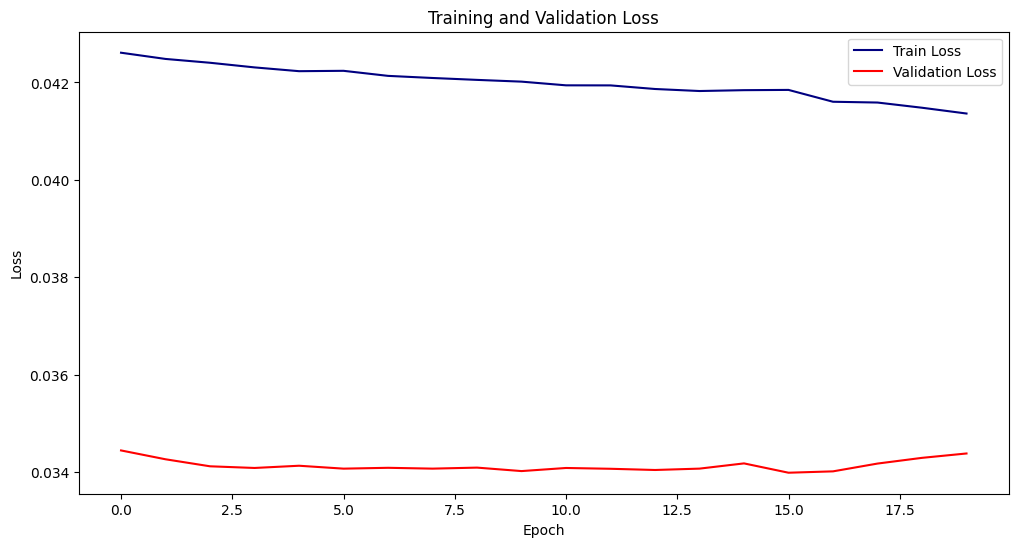

In [68]:
train(cnn_encoder, x_train, y_train, x_test, y_test, criterion, num_epochs=20, learning_rate=1e-03, monitor_gradients=False)

### Classic CNN (no pooling)

In [14]:
# cnn_encoder = CNN_encoder(seq_len=seq_len, n_channels=2, num_classes=1,
#                         #   conv_params_1 = {"channels" : 16, "kernel_size": 20, "stride": 1},
#                         #   conv_params_2 = {"channels" : 32, "kernel_size": 10, "stride": 1},
#                         #   conv_params_3 = {"channels" : 64, "kernel_size": 5, "stride": 1},
#                           )
conv_params_1 = {"channels" : 8 , "kernel_size": 60, "stride": 5}
conv_params_2 = {"channels" : 16, "kernel_size": 40, "stride": 5}
conv_params_3 = {"channels" : 32, "kernel_size": 20, "stride": 1}
# conv_params_4 = {"channels" : 64, "kernel_size": 5 , "stride": 1}
temporal_cnn_deep = TemporalCNN(seq_len, n_channels=2, conv_params_1=conv_params_1, conv_params_2=conv_params_2, conv_params_3=conv_params_3, conv_params_4=conv_params_4)
torchsummary.summary(temporal_cnn_deep, (seq_len, 2))
criterion = nn.BCELoss()
print(x_2022.shape, y_2022.shape)
print(x_2024.shape, y_2024.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 8, 289]             960
       BatchNorm1d-2               [-1, 8, 289]              16
            Conv1d-3               [-1, 16, 51]           5,120
       BatchNorm1d-4               [-1, 16, 51]              32
            Conv1d-5               [-1, 32, 34]          10,240
       BatchNorm1d-6               [-1, 32, 34]              64
            Linear-7                [-1, 34, 1]              33
            Linear-8                 [-1, 1, 1]              35
Total params: 16,500
Trainable params: 16,500
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.06
Estimated Total Size (MB): 0.14
----------------------------------------------------------------
torch.Size([616, 4, 1500, 2]) torch.Size([61

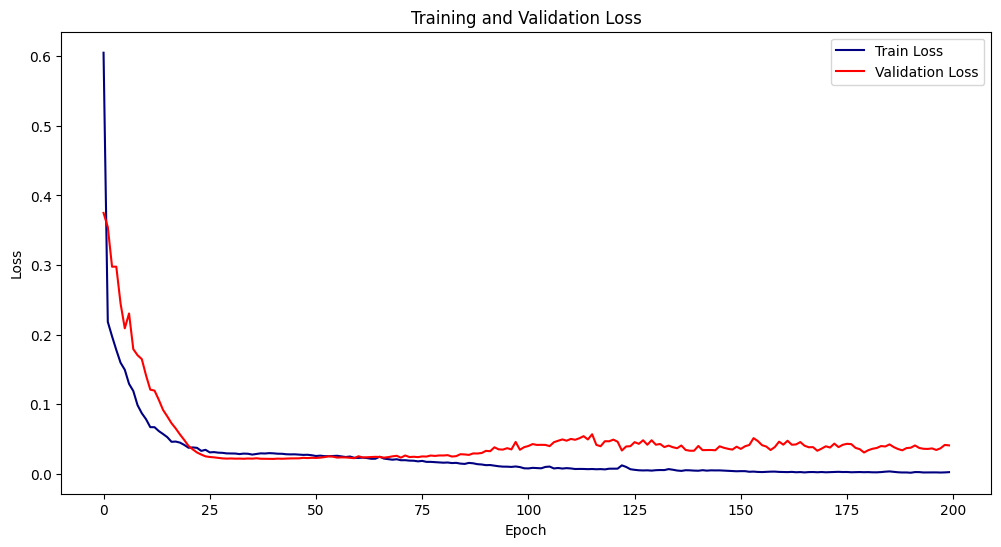

In [22]:
train(temporal_cnn_deep, x_train, y_train, x_test, y_test, criterion = criterion, num_epochs=200, learning_rate=5e-04, monitor_gradients=False)     

# LSTM w/ Attention

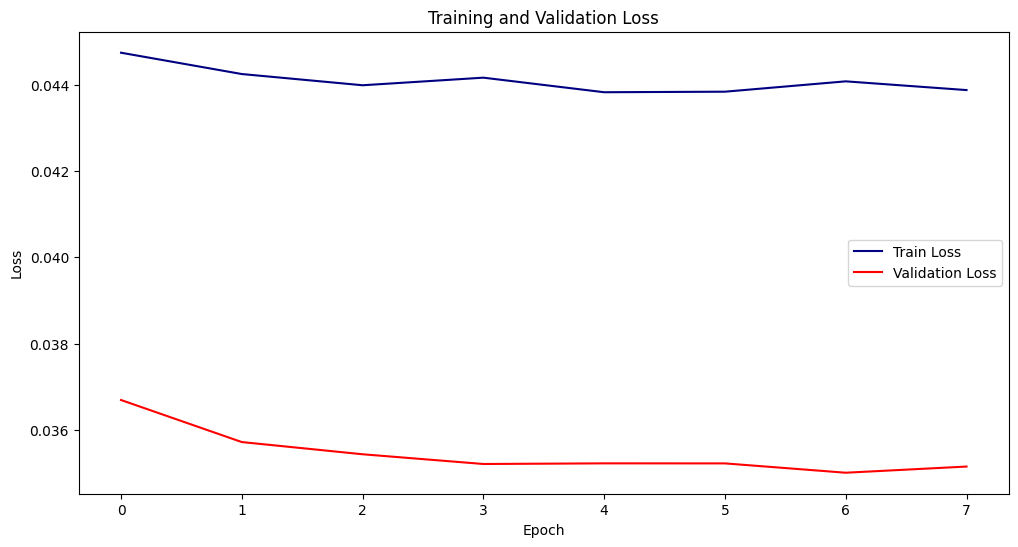

KeyboardInterrupt: 

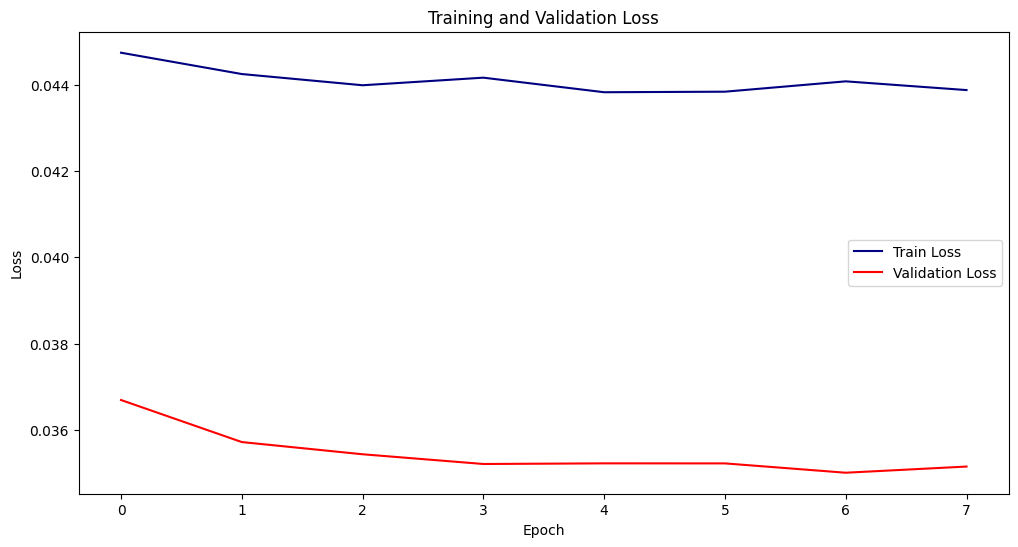

In [79]:
lstm_attention = LSTMWithAttention(input_dim, hidden_dim, num_layers, dropout, seq_len=seq_len)
rand_input = torch.rand((4, seq_len, input_dim))
output = lstm_attention(rand_input)
train(lstm_attention, x_train, y_train, x_test, y_test, criterion = criterion, num_epochs=20, learning_rate=1e-03, monitor_gradients=False)

# Optimize learning hyperparameters

In [34]:
# Define the objective function
x_train, y_train = x_2022, y_2022
x_test, y_test = x_2024, y_2024

def objective(trial):
    # Define the hyperparameters to be optimized
    stride = trial.suggest_int('stride', 1, 5)

    conv_params_1 = {"channels" : 4 , "kernel_size": 20, "stride": stride}
    conv_params_2 = {"channels" : 8, "kernel_size": 10, "stride": stride}
    conv_params_3 = {"channels" : 16, "kernel_size": 5, "stride": 1}

    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log = True)
    num_epochs = 20
    
    # Define the model
    model = CNN_encoder(conv_params_1=conv_params_1, conv_params_2=conv_params_2, conv_params_3=conv_params_3, seq_len=seq_len)
    torchsummary.summary(model, (seq_len, 2))

    # Define the loss function and optimizer
    criterion = nn.BCELoss()
    criterion_eval = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in range(x_train.shape[0]):
            x_train_batch = x_train[batch]
            y_train_batch = y_train[batch]
            
            model.train()
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(x_train_batch)
            loss = criterion(outputs.squeeze(), torch.tensor(y_train_batch, dtype=torch.float32))
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            train_loss += loss.item()/x_train.shape[0]

        # add validation on test set
        with torch.no_grad():
            model.eval()
            outputs = []
            for batch in range(x_test.shape[0]):
                x_test_batch = x_test[batch]
                y_test_batch = y_test[batch]            
                outputs.append(model(x_test_batch).squeeze().detach().numpy())
            val_loss = criterion_eval(torch.tensor(outputs).squeeze(), torch.tensor(y_test).squeeze()).item()
            torch.save(model.state_dict(), f'model_checkpoints/best_model_{str(trial.params.items())}.pth')

    return val_loss

# Example usage
# Assuming x_data and y_data are already defined
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2025-01-15 11:18:47,561] A new study created in memory with name: no-name-4668cc74-4700-490c-900a-2b40ea01fd92
C:\Users\TomFi\AppData\Local\Temp\ipykernel_26072\3872260108.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs.squeeze(), torch.tensor(y_train_batch, dtype=torch.float32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 4, 501]             160
       BatchNorm1d-2               [-1, 4, 501]               8
         MaxPool1d-3               [-1, 4, 250]               0
            Conv1d-4                [-1, 8, 84]             320
       BatchNorm1d-5                [-1, 8, 84]              16
         MaxPool1d-6                [-1, 8, 42]               0
            Conv1d-7               [-1, 16, 42]             640
       BatchNorm1d-8               [-1, 16, 42]              32
         MaxPool1d-9               [-1, 16, 21]               0
           Linear-10                [-1, 21, 1]              17
           Linear-11                 [-1, 1, 1]              22
Total params: 1,215
Trainable params: 1,215
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/back

C:\Users\TomFi\AppData\Local\Temp\ipykernel_26072\3872260108.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_loss = criterion_eval(torch.tensor(outputs).squeeze(), torch.tensor(y_test).squeeze()).item()
[I 2025-01-15 11:19:36,984] Trial 0 finished with value: 0.6184689998626709 and parameters: {'stride': 3, 'learning_rate': 0.0006373889089782695}. Best is trial 0 with value: 0.6184689998626709.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 4, 376]             160
       BatchNorm1d-2               [-1, 4, 376]               8
         MaxPool1d-3               [-1, 4, 188]               0
            Conv1d-4                [-1, 8, 48]             320
       BatchNorm1d-5                [-1, 8, 48]              16
         MaxPool1d-6                [-1, 8, 24]               0
            Conv1d-7               [-1, 16, 24]             640
       BatchNorm1d-8               [-1, 16, 24]              32
         MaxPool1d-9               [-1, 16, 12]               0
           Linear-10                [-1, 12, 1]              17
           Linear-11                 [-1, 1, 1]              13
Total params: 1,206
Trainable params: 1,206
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/back

[I 2025-01-15 11:20:19,805] Trial 1 finished with value: 0.618449330329895 and parameters: {'stride': 4, 'learning_rate': 0.0005057996067620005}. Best is trial 1 with value: 0.618449330329895.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 4, 751]             160
       BatchNorm1d-2               [-1, 4, 751]               8
         MaxPool1d-3               [-1, 4, 375]               0
            Conv1d-4               [-1, 8, 188]             320
       BatchNorm1d-5               [-1, 8, 188]              16
         MaxPool1d-6                [-1, 8, 94]               0
            Conv1d-7               [-1, 16, 94]             640
       BatchNorm1d-8               [-1, 16, 94]              32
         MaxPool1d-9               [-1, 16, 47]               0
           Linear-10                [-1, 47, 1]              17
           Linear-11                 [-1, 1, 1]              48
Total params: 1,241
Trainable params: 1,241
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/back

[I 2025-01-15 11:21:15,794] Trial 2 finished with value: 0.6125990748405457 and parameters: {'stride': 2, 'learning_rate': 0.0007681968778806081}. Best is trial 2 with value: 0.6125990748405457.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 4, 301]             160
       BatchNorm1d-2               [-1, 4, 301]               8
         MaxPool1d-3               [-1, 4, 150]               0
            Conv1d-4                [-1, 8, 31]             320
       BatchNorm1d-5                [-1, 8, 31]              16
         MaxPool1d-6                [-1, 8, 15]               0
            Conv1d-7               [-1, 16, 15]             640
       BatchNorm1d-8               [-1, 16, 15]              32
         MaxPool1d-9                [-1, 16, 7]               0
           Linear-10                 [-1, 7, 1]              17
           Linear-11                 [-1, 1, 1]               8
Total params: 1,201
Trainable params: 1,201
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/back

[I 2025-01-15 11:22:07,577] Trial 3 finished with value: 0.6105263233184814 and parameters: {'stride': 5, 'learning_rate': 0.009523511500634909}. Best is trial 3 with value: 0.6105263233184814.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 4, 376]             160
       BatchNorm1d-2               [-1, 4, 376]               8
         MaxPool1d-3               [-1, 4, 188]               0
            Conv1d-4                [-1, 8, 48]             320
       BatchNorm1d-5                [-1, 8, 48]              16
         MaxPool1d-6                [-1, 8, 24]               0
            Conv1d-7               [-1, 16, 24]             640
       BatchNorm1d-8               [-1, 16, 24]              32
         MaxPool1d-9               [-1, 16, 12]               0
           Linear-10                [-1, 12, 1]              17
           Linear-11                 [-1, 1, 1]              13
Total params: 1,206
Trainable params: 1,206
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/back

[I 2025-01-15 11:22:57,631] Trial 4 finished with value: 0.6157541871070862 and parameters: {'stride': 4, 'learning_rate': 0.0004708509240011063}. Best is trial 3 with value: 0.6105263233184814.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 4, 501]             160
       BatchNorm1d-2               [-1, 4, 501]               8
         MaxPool1d-3               [-1, 4, 250]               0
            Conv1d-4                [-1, 8, 84]             320
       BatchNorm1d-5                [-1, 8, 84]              16
         MaxPool1d-6                [-1, 8, 42]               0
            Conv1d-7               [-1, 16, 42]             640
       BatchNorm1d-8               [-1, 16, 42]              32
         MaxPool1d-9               [-1, 16, 21]               0
           Linear-10                [-1, 21, 1]              17
           Linear-11                 [-1, 1, 1]              22
Total params: 1,215
Trainable params: 1,215
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/back

[I 2025-01-15 11:23:41,833] Trial 5 finished with value: 0.611587405204773 and parameters: {'stride': 3, 'learning_rate': 0.006941822614571199}. Best is trial 3 with value: 0.6105263233184814.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 4, 751]             160
       BatchNorm1d-2               [-1, 4, 751]               8
         MaxPool1d-3               [-1, 4, 375]               0
            Conv1d-4               [-1, 8, 188]             320
       BatchNorm1d-5               [-1, 8, 188]              16
         MaxPool1d-6                [-1, 8, 94]               0
            Conv1d-7               [-1, 16, 94]             640
       BatchNorm1d-8               [-1, 16, 94]              32
         MaxPool1d-9               [-1, 16, 47]               0
           Linear-10                [-1, 47, 1]              17
           Linear-11                 [-1, 1, 1]              48
Total params: 1,241
Trainable params: 1,241
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/back

[I 2025-01-15 11:24:30,027] Trial 6 finished with value: 0.6096203327178955 and parameters: {'stride': 2, 'learning_rate': 0.009473737291749334}. Best is trial 6 with value: 0.6096203327178955.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 4, 751]             160
       BatchNorm1d-2               [-1, 4, 751]               8
         MaxPool1d-3               [-1, 4, 375]               0
            Conv1d-4               [-1, 8, 188]             320
       BatchNorm1d-5               [-1, 8, 188]              16
         MaxPool1d-6                [-1, 8, 94]               0
            Conv1d-7               [-1, 16, 94]             640
       BatchNorm1d-8               [-1, 16, 94]              32
         MaxPool1d-9               [-1, 16, 47]               0
           Linear-10                [-1, 47, 1]              17
           Linear-11                 [-1, 1, 1]              48
Total params: 1,241
Trainable params: 1,241
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/back

[I 2025-01-15 11:25:14,921] Trial 7 finished with value: 0.6107081174850464 and parameters: {'stride': 2, 'learning_rate': 0.00770667199578222}. Best is trial 6 with value: 0.6096203327178955.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 4, 1501]             160
       BatchNorm1d-2              [-1, 4, 1501]               8
         MaxPool1d-3               [-1, 4, 750]               0
            Conv1d-4               [-1, 8, 751]             320
       BatchNorm1d-5               [-1, 8, 751]              16
         MaxPool1d-6               [-1, 8, 375]               0
            Conv1d-7              [-1, 16, 375]             640
       BatchNorm1d-8              [-1, 16, 375]              32
         MaxPool1d-9              [-1, 16, 187]               0
           Linear-10               [-1, 187, 1]              17
           Linear-11                 [-1, 1, 1]             188
Total params: 1,381
Trainable params: 1,381
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/back

[I 2025-01-15 11:26:07,657] Trial 8 finished with value: 0.6275457143783569 and parameters: {'stride': 1, 'learning_rate': 0.00011126213840025334}. Best is trial 6 with value: 0.6096203327178955.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 4, 1501]             160
       BatchNorm1d-2              [-1, 4, 1501]               8
         MaxPool1d-3               [-1, 4, 750]               0
            Conv1d-4               [-1, 8, 751]             320
       BatchNorm1d-5               [-1, 8, 751]              16
         MaxPool1d-6               [-1, 8, 375]               0
            Conv1d-7              [-1, 16, 375]             640
       BatchNorm1d-8              [-1, 16, 375]              32
         MaxPool1d-9              [-1, 16, 187]               0
           Linear-10               [-1, 187, 1]              17
           Linear-11                 [-1, 1, 1]             188
Total params: 1,381
Trainable params: 1,381
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/back

[I 2025-01-15 11:26:59,450] Trial 9 finished with value: 0.6103310585021973 and parameters: {'stride': 1, 'learning_rate': 0.0010771071036542014}. Best is trial 6 with value: 0.6096203327178955.


Best trial:
  Value: 0.6096203327178955
  Params: 
    stride: 2
    learning_rate: 0.009473737291749334


# Evaluating models

tensor([[ 0.0442,  0.0534, -0.0337,  0.0243]])
tensor([[ 0.0485, -0.0062, -0.0209,  0.0117]])
tensor([[0.0308, 0.0225, 0.0081, 0.0415]])
tensor([[ 0.0578,  0.0233, -0.0038, -0.0266]])
tensor([[ 0.1284,  0.1027, -0.0114, -0.0008]])
tensor([[ 0.0355,  0.0427, -0.0326, -0.0022]])
tensor([[ 0.0369, -0.0113, -0.0321,  0.0697]])
tensor([[-0.0106, -0.0229,  0.0080,  0.2447]])
tensor([[ 0.0426,  0.0052, -0.0237,  0.0561]])
tensor([[ 0.0588,  0.0075, -0.0080,  0.0070]])
tensor([[ 0.0707,  0.0081, -0.0004,  0.0397]])
tensor([[ 0.0007, -0.1567,  0.0306,  0.1721]])
tensor([[0.0091, 0.0195, 0.0400, 0.1084]])
tensor([[ 0.0319, -0.0260,  0.0457,  0.1508]])
tensor([[ 0.0592,  0.0305, -0.0079,  0.0012]])
tensor([[ 0.1570, -0.0674,  0.0161, -0.0198]])
tensor([[ 0.0538,  0.0592, -0.0200, -0.0071]])
tensor([[-0.0240,  0.0601,  0.0214,  0.0410]])
tensor([[ 0.1729, -0.2011, -0.0932,  0.1206]])
tensor([[ 0.0630, -0.0016, -0.0026,  0.0218]])
tensor([[ 0.0552, -0.0054, -0.0178,  0.0060]])
tensor([[ 0.0404, -0.

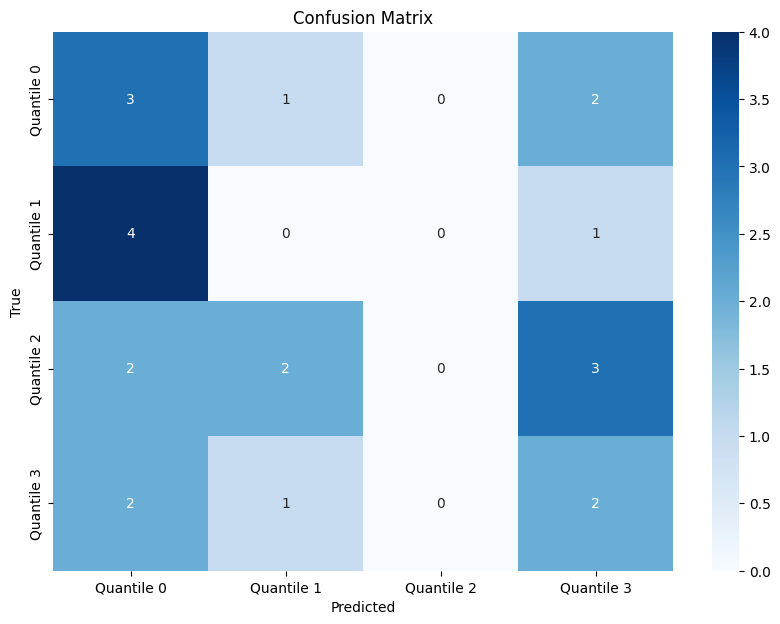

Classification Report:
              precision    recall  f1-score   support

  Quantile 0       0.27      0.50      0.35         6
  Quantile 1       0.00      0.00      0.00         5
  Quantile 2       0.00      0.00      0.00         7
  Quantile 3       0.25      0.40      0.31         5

    accuracy                           0.22        23
   macro avg       0.13      0.23      0.17        23
weighted avg       0.13      0.22      0.16        23



c:\Users\TomFi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\TomFi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\TomFi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [129]:
def evaluate_multiclass_model(model, x_test, y_test, class_names):
    # Set the model to evaluation mode
    model.eval()
    
    # Forward pass
    with torch.no_grad():
        outputs = []
        preds = []
        for batch in range(x_test.shape[0]):
            x_test_batch = x_test[batch][0,:,:].reshape(1, x_test.shape[2], x_test.shape[3])
            logits = model(x_test_batch).reshape(1, -1)
            outputs.append(logits)
            print(logits)
            _, pred = torch.max(logits, -1)
            preds.append(pred)
        preds = torch.cat(preds)
        truth = torch.argmax(y_test[:,0,:], dim = -1).flatten()
    
    # print(preds, y_test.shape)
    # Calculate accuracy
    accuracy = torch.sum(preds == truth).item() / len(truth)
    print(f'Accuracy: {accuracy:.4f}')
    
    # Generate confusion matrix
    cm = confusion_matrix(truth, preds)
    print('Confusion Matrix:')
    print(cm)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Classification report
    report = classification_report(truth, preds, target_names=class_names)
    print('Classification Report:')
    print(report)

# Example usage
# Assuming x_test, y_test, and model are already defined
class_names = ['Quantile 0', 'Quantile 1', 'Quantile 2', 'Quantile 3']
evaluate_multiclass_model(cnn_encoder, x_test, y_test_cats, class_names)

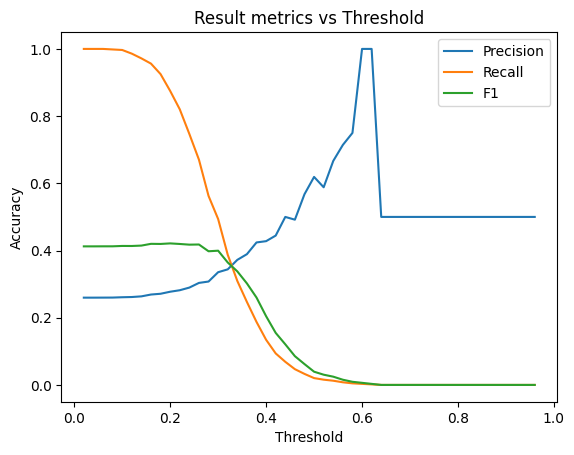

In [16]:
def eval_binaryclass(model, x_test, y_test):
    outputs = []
    for batch in range(x_test.shape[0]):
        x_test_batch = x_test[batch]
        outputs.append(model(x_test_batch).squeeze().detach().numpy())
    outputs = np.array(outputs).flatten()
    test_HP_adhd = np.array(y_test).flatten()
    threshold = np.arange(0.02, 0.98, 0.02)
    accuracy, precision, recall = [], [], []
    for t in threshold:
        tp = np.sum((outputs > t) & (test_HP_adhd == 1)) + 1e-10
        tn = np.sum((outputs <= t) & (test_HP_adhd == 0))+ 1e-10
        fp = np.sum((outputs > t) & (test_HP_adhd == 0))+ 1e-10
        fn = np.sum((outputs <= t) & (test_HP_adhd == 1))+ 1e-10
        # print(f"TP : {tp}, TN : {tn}, FP : {fp}, FN : {fn}")
        precision.append(tp / (tp + fp))
        recall.append(tp / (tp + fn))
    f1 = 2 * np.array(precision) * np.array(recall) / (np.array(precision) + np.array(recall))
    plt.plot(threshold, precision, label = 'Precision')
    plt.plot(threshold, recall, label = 'Recall')
    plt.plot(threshold, f1, label = 'F1')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.title('Result metrics vs Threshold')
    plt.legend()
    plt.show()

    return f1, outputs

f1, outputs = eval_binaryclass(temporal_cnn_deep, x_2022, y_2022)

In [69]:
def eval_score(model, x_test, y_test):
    outputs = []
    for batch in range(x_test.shape[0]):
        x_test_batch = x_test[batch]
        outputs.append(model(x_test_batch).squeeze().detach().numpy())
    outputs = np.array(outputs).flatten()
    test_HP_adhd = np.array(y_test).flatten()
    outputs_unnorm = scaler.inverse_transform(outputs.reshape(-1,1)).flatten()
    test_HP_adhd_unnorm = scaler.inverse_transform(test_HP_adhd.reshape(-1,1)).flatten()
    mse = np.mean((outputs - test_HP_adhd) ** 2)
    print(f'Mean Squared Error: {mse}')
    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    ax[0].plot(outputs_unnorm, label='Predictions', c = 'g')
    ax[0].plot(test_HP_adhd_unnorm, label='True values', c = 'orange')
    ax[0].legend(loc = 'upper right')
    ax[0].set_xlabel('Sample from test set')
    ax[0].set_ylabel('ASRS Score')
    ax[0].set_title('Predictions vs True values')
    ax[1].hist(outputs_unnorm, bins=40, alpha=0.5, label='Predictions', color='green', edgecolor='black', density=True)
    ax[1].hist(test_HP_adhd_unnorm, bins=40, alpha=0.5, label='True values', color='orange', edgecolor='black', density=True)
    ax[1].legend(loc = 'upper right')
    ax[1].set_xlabel('ASRS Score')
    ax[1].set_title('Distribution of Predictions vs True normalized scores')
    plt.show()
    return mse, outputs

Mean Squared Error: 0.03502889722585678


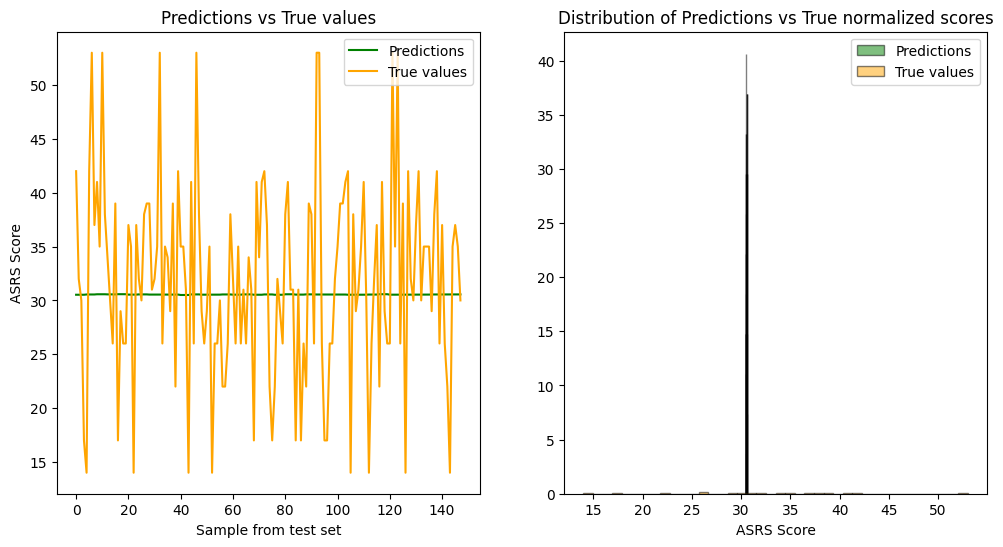

In [80]:
mse, outputs = eval_score(lstm_attention, x_test, y_test)

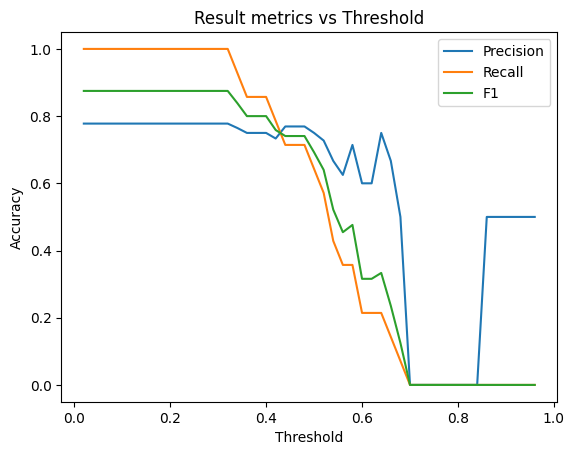

In [21]:
f1, outputs = eval_binaryclass(temporal_cnn, x_test, y_test_clf)